# Understanding and Detecting Model Drift


This notebook provides a hands-on demonstration of **model drift**, a critical concept in machine learning operations (MLOps). We will explore what model drift is, why it occurs, and how to detect it using Python libraries.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand what model drift is and why it matters
2. Distinguish between different types of drift
3. Simulate drift in a data stream
4. Implement drift detection algorithms
5. Visualize and interpret drift detection results

## 1. What is Model Drift?

**Model drift**, also known as **model decay**, refers to the degradation of a machine learning model's performance over time. This phenomenon occurs when the statistical properties of the data the model encounters in production diverge from the data it was trained on.

### Why Does Model Drift Matter?

When model drift occurs, the model's predictions become less accurate, leading to:
- Poor decision-making
- Decreased business value
- Potential financial losses
- Reduced user trust

### Real-World Example

Consider a credit card fraud detection model trained on data from 2020. As fraudsters develop new techniques in 2021 and beyond, the patterns of fraudulent transactions change. The model, still operating on 2020 patterns, begins to miss new types of fraud—this is model drift in action.

## 2. Types of Model Drift

There are three main types of drift that can affect machine learning models:

### 2.1 Concept Drift

**Concept drift** occurs when the relationship between the input variables (features) and the target variable changes over time. In mathematical terms, the conditional probability P(Y|X) changes, where Y is the target and X represents the features.

**Example:** In a spam email classifier, what constitutes "spam" evolves as spammers adapt their tactics. An email pattern that was spam yesterday might be legitimate today, or vice versa.

**Types of Concept Drift:**
- **Sudden (Abrupt):** A rapid change in the relationship (e.g., COVID-19 pandemic impact on consumer behavior)
- **Gradual:** Slow evolution over time (e.g., changing fashion trends)
- **Incremental:** Step-by-step changes
- **Recurring (Seasonal):** Patterns that repeat periodically (e.g., holiday shopping patterns)

### 2.2 Data Drift (Covariate Shift)

**Data drift** happens when the statistical distribution of the input features changes, but the relationship between features and target remains constant. In mathematical terms, P(X) changes, but P(Y|X) stays the same.

**Example:** A house price prediction model trained on urban data is deployed in a rural area. The distribution of features (house size, lot size, etc.) is different, even though the relationship between these features and price remains similar.

### 2.3 Upstream Data Changes

**Upstream data changes** occur when modifications in the data pipeline affect the data quality or format.

**Examples:**
- Change in measurement units (miles to kilometers)
- Change in data collection methods
- Software updates that alter feature engineering
- Changes in data sources

## 3. Setting Up Our Environment

Let's import the necessary libraries for our drift detection demonstration.

## 3.1 Why Start with Synthetic Data?

Before we dive into the code, you might wonder: "Why use synthetic (artificial) data instead of real data?"

**Educational Benefits:**
- **Controlled Environment**: We know exactly when and how drift occurs, making it easier to validate our detection methods
- **Clear Patterns**: Without noise from real-world complexity, we can focus on understanding the drift detection algorithms
- **Reproducibility**: Everyone gets the same results, making it easier to learn together

**Real-World Application**: After mastering these concepts with synthetic data, you'll apply the same techniques to real datasets where drift is less obvious but just as important to detect.

> **Coming Up**: Later in this notebook, we'll also work with a realistic machine learning model to see how drift affects actual predictions!

In [18]:
!uv pip install river

Using Python 3.12.11 environment at: /Users/tarekatwan/Repos/MyWork/Teach/repos/adv_ml_ds/dev1
Audited 1 package in 25ms


In [19]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from river import drift
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4


## 4. Simulating Data Drift

To understand drift detection, we'll first create a synthetic data stream that contains a drift point. This will help us visualize what drift looks like and test our detection algorithms.

### Scenario

Imagine we're monitoring a sensor that measures temperature. Initially, the sensor reads values around 20°C (68°F). After some time, due to environmental changes or sensor calibration issues, the readings shift to around 25°C (77°F).

In [20]:
# Generate synthetic data stream with drift

# Stream 1: Initial distribution (mean=20, std=2)
stream_1 = np.random.normal(20, 2, 500)

# Stream 2: Drifted distribution (mean=25, std=2.5)
stream_2 = np.random.normal(25, 2.5, 500)

# Concatenate to create a single stream with drift at index 500
data_stream = np.concatenate((stream_1, stream_2))

print(f"Total data points: {len(data_stream)}")
print(f"Stream 1 - Mean: {stream_1.mean():.2f}, Std: {stream_1.std():.2f}")
print(f"Stream 2 - Mean: {stream_2.mean():.2f}, Std: {stream_2.std():.2f}")
print(f"\nDrift introduced at index: 500")

Total data points: 1000
Stream 1 - Mean: 20.01, Std: 1.96
Stream 2 - Mean: 25.08, Std: 2.44

Drift introduced at index: 500


### Visualizing the Data Stream

Let's plot our data stream to see the drift visually. The red vertical line indicates where we introduced the drift.

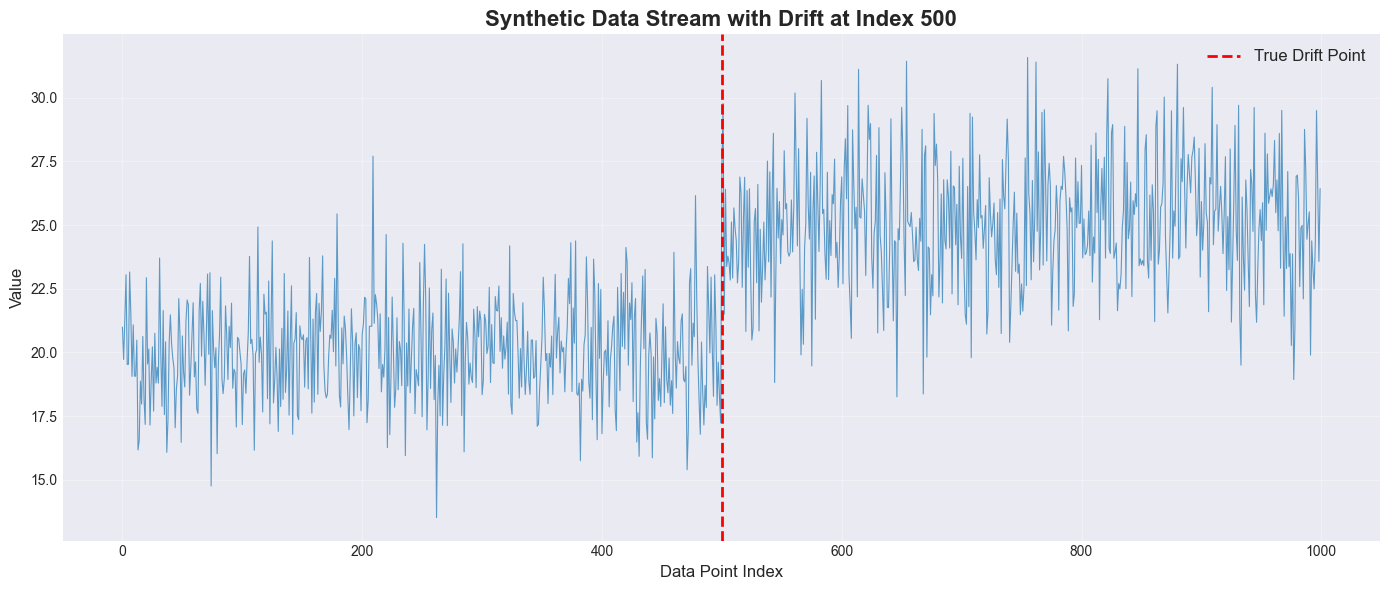

Notice how the data values shift upward after index 500.
This represents a sudden drift in the data distribution.


In [21]:
# Plot the data stream
plt.figure(figsize=(14, 6))
plt.plot(data_stream, alpha=0.7, linewidth=0.8)
plt.axvline(x=500, color='red', linestyle='--', linewidth=2, label='True Drift Point')
plt.title('Synthetic Data Stream with Drift at Index 500', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice how the data values shift upward after index 500.")
print("This represents a sudden drift in the data distribution.")

## 5. Drift Detection with ADWIN

Now we'll use a drift detection algorithm to automatically identify the drift point. We'll use **ADWIN (ADaptive WINdowing)**, a popular algorithm for detecting changes in data streams.

### How ADWIN Works

ADWIN maintains a sliding window of recent data points and continuously checks if the distribution in the window has changed significantly. When it detects a change, it signals a drift and adjusts the window size.

**Key Features:**
- No need to set a fixed window size
- Adapts to the rate of change
- Provides rigorous guarantees on false positive rates
- Effective for both sudden and gradual drifts

### 5.1 Understanding ADWIN Parameters

Before we use ADWIN, let's understand how to configure it:

**Key Parameter: `delta`**
- **Purpose**: Controls the sensitivity of drift detection (confidence level)
- **Range**: 0 to 1 (typically 0.002 to 0.1)
- **Trade-off**:
  - **Lower delta** (e.g., 0.002): More sensitive → Detects drift quickly BUT more false alarms
  - **Higher delta** (e.g., 0.1): Less sensitive → Fewer false alarms BUT slower detection
- **Default**: 0.002 (99.8% confidence level)

**How ADWIN Works - Simplified:**

1. **Maintains a Window**: Keeps a sliding window of recent data points
2. **Splits and Compares**: Continuously divides the window into two parts and compares their statistics
3. **Detects Change**: If the two parts are significantly different, drift is detected
4. **Adapts Window Size**: Automatically grows or shrinks the window based on detected changes

**When to Use ADWIN:**
- ✅ Monitoring continuous numerical data (sensor readings, model predictions, feature values)
- ✅ When you don't know the expected drift pattern
- ✅ When both sudden and gradual drift might occur
- ✅ Real-time streaming applications

**Advantages:**
- No need to manually set window size
- Rigorous statistical guarantees
- Memory efficient
- Works for various drift types

In [22]:
# Initialize the ADWIN drift detector
adwin = drift.ADWIN()

# Track detected drift points
drift_points = []

# Process the stream and detect drift
print("Processing data stream...\n")

for i, value in enumerate(data_stream):
    # Update the detector with the new value
    adwin.update(value)
    
    # Check if drift was detected
    if adwin.drift_detected:
        print(f"Drift detected at index: {i}")
        drift_points.append(i)

print(f"\nTotal drift points detected: {len(drift_points)}")
print(f"Detected drift points: {drift_points}")

Processing data stream...

Drift detected at index: 511

Total drift points detected: 1
Detected drift points: [511]


### 5.2 Interpreting ADWIN Results

**What to Expect:**

When running ADWIN on a data stream, you might see:
- **Single Detection**: One drift point near the actual change (ideal scenario)
- **Multiple Detections**: Several drift points in a short period (common with noisy data or gradual drift)
- **No Detection**: Either no drift exists, or delta is too high

**Why Multiple Drift Points?**

You might detect drift at indices like 502, 503, 505, etc., even though the true drift is at 500. This happens because:
1. **Statistical Fluctuation**: Random variation in data can trigger additional alerts
2. **Window Adjustment**: After detecting drift, ADWIN resets its window and may detect the "tail" of the change
3. **Sensitivity**: With default delta=0.002, ADWIN is very sensitive

**What This Means in Practice:**
- The first detection point is usually the most important
- Multiple close detections typically indicate the same drift event
- In production, you'd implement a "cooldown period" to avoid repeated alerts for the same drift

### Visualizing Detected Drift

Let's visualize the data stream along with the detected drift points.

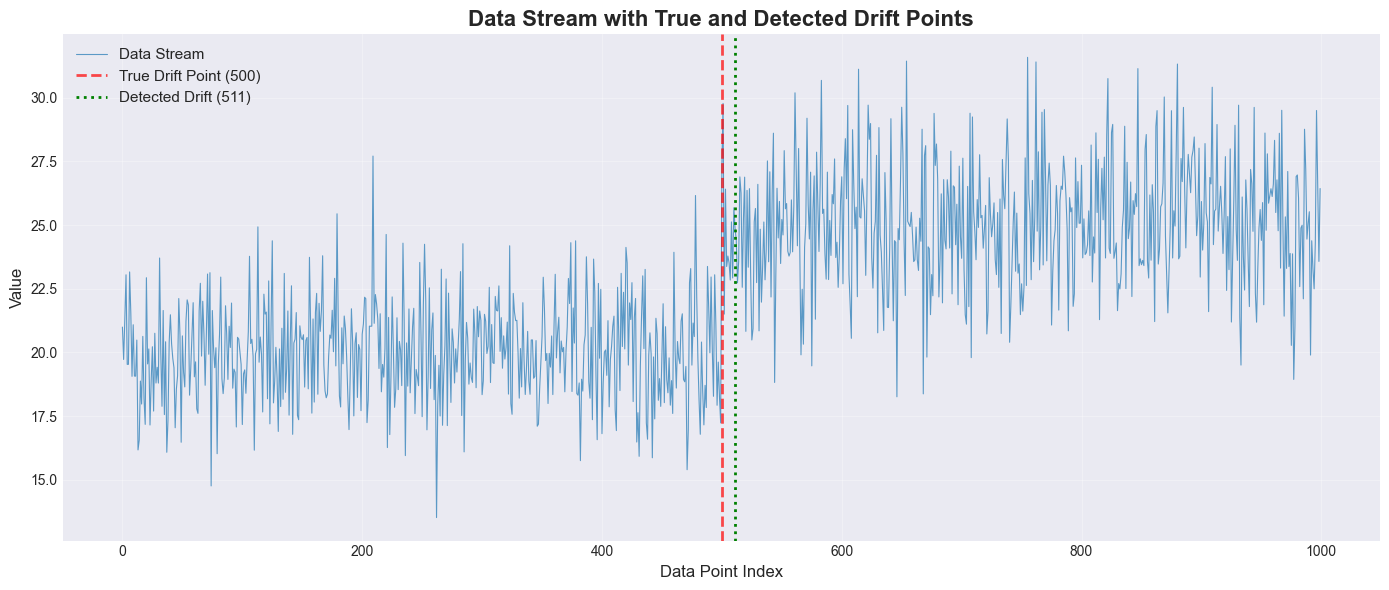


Detection Performance:
  - True drift point: 500
  - First detected drift: 511
  - Detection delay: 11 data points


In [23]:
# Plot the stream with detected drift points
plt.figure(figsize=(14, 6))
plt.plot(data_stream, alpha=0.7, linewidth=0.8, label='Data Stream')
plt.axvline(x=500, color='red', linestyle='--', linewidth=2, label='True Drift Point (500)', alpha=0.7)

# Mark detected drift points
for idx, drift_point in enumerate(drift_points):
    if idx == 0:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2, 
                   label=f'Detected Drift ({drift_point})')
    else:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2)

plt.title('Data Stream with True and Detected Drift Points', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate detection accuracy
if drift_points:
    detection_delay = drift_points[0] - 500
    print(f"\nDetection Performance:")
    print(f"  - True drift point: 500")
    print(f"  - First detected drift: {drift_points[0]}")
    print(f"  - Detection delay: {detection_delay} data points")
else:
    print("\nNo drift was detected by the algorithm.")

### 5.3 Analyzing Detection Performance

**Key Metrics to Evaluate Drift Detection:**

1. **Detection Delay**: How many data points after the true drift point was it detected?
   - **Calculation**: `detected_index - true_drift_index`
   - **Goal**: Minimize delay while avoiding false positives

2. **False Positive Rate**: How often does the detector signal drift when there isn't any?
   - Important in stable periods before/after drift

3. **Detection Accuracy**: Did we catch all real drift events?

**Performance Trade-offs:**

| Metric | Lower Delta | Higher Delta |
|--------|-------------|--------------|
| Detection Speed | ⚡ Faster | 🐌 Slower |
| False Positives | ⚠️ More | ✅ Fewer |
| Sensitivity | 📈 High | 📉 Low |

**What Makes Good Detection?**
- Detecting within 10-50 data points is generally excellent for sudden drift
- For gradual drift, detection anywhere in the transition zone is acceptable
- No false positives in stable regions is ideal but rare with very low delta

## 6. Experimenting with Gradual Drift

Let's create a more challenging scenario: **gradual drift**. Instead of an abrupt change, the data distribution shifts slowly over time.

### 6.1 Why Gradual Drift is Harder to Detect

**The Challenge:**

Gradual drift is more common in real-world scenarios but harder to detect because:

1. **Subtle Changes**: Each individual data point looks similar to previous ones
2. **Moving Target**: The distribution is constantly shifting, not just switching once
3. **Detection Ambiguity**: It's unclear when exactly the drift "starts" and "ends"

**Real-World Examples:**
- **Customer Behavior**: Shopping preferences slowly evolve with trends
- **Market Dynamics**: Stock prices gradually shift with economic changes
- **Sensor Degradation**: Equipment slowly wears down, producing different readings
- **Seasonal Patterns**: Temperature, sales, traffic gradually change with seasons

**Expected Detector Behavior:**

Unlike sudden drift (1 clean detection), gradual drift often triggers:
- ✅ **Multiple detections** throughout the transition period
- ✅ **Scattered alerts** as the algorithm notices ongoing changes
- ✅ **No detection** in early transition (change too subtle)

This is **normal and expected** - not a failure of the algorithm!

In [24]:
# Create a gradual drift scenario
np.random.seed(42)

# Initial stable period
stable_data = np.random.normal(20, 2, 300)

# Gradual transition period (300 points)
transition_length = 300
transition_data = []
for i in range(transition_length):
    # Gradually shift mean from 20 to 25
    current_mean = 20 + (5 * i / transition_length)
    # Gradually increase std from 2 to 2.5
    current_std = 2 + (0.5 * i / transition_length)
    transition_data.append(np.random.normal(current_mean, current_std))

transition_data = np.array(transition_data)

# New stable period
new_stable_data = np.random.normal(25, 2.5, 400)

# Combine all periods
gradual_stream = np.concatenate([stable_data, transition_data, new_stable_data])

print(f"Gradual drift stream created:")
print(f"  - Stable period 1: 0-299 (mean ≈ 20)")
print(f"  - Transition period: 300-599 (mean shifts from 20 to 25)")
print(f"  - Stable period 2: 600-999 (mean ≈ 25)")

Gradual drift stream created:
  - Stable period 1: 0-299 (mean ≈ 20)
  - Transition period: 300-599 (mean shifts from 20 to 25)
  - Stable period 2: 600-999 (mean ≈ 25)


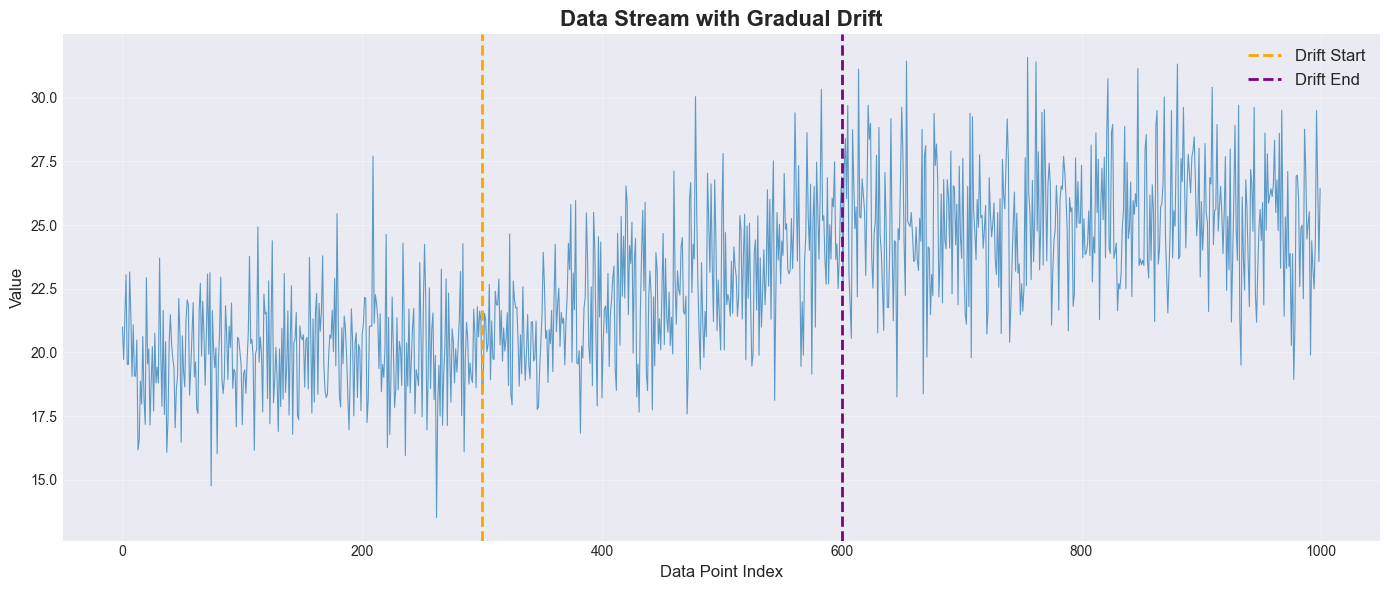

In [25]:
# Visualize gradual drift
plt.figure(figsize=(14, 6))
plt.plot(gradual_stream, alpha=0.7, linewidth=0.8)
plt.axvline(x=300, color='orange', linestyle='--', linewidth=2, label='Drift Start')
plt.axvline(x=600, color='purple', linestyle='--', linewidth=2, label='Drift End')
plt.title('Data Stream with Gradual Drift', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Detecting Gradual Drift

In [26]:
# Detect drift in gradual stream
adwin_gradual = drift.ADWIN()
gradual_drift_points = []

print("Detecting gradual drift...\n")

for i, value in enumerate(gradual_stream):
    adwin_gradual.update(value)
    if adwin_gradual.drift_detected:
        print(f"Drift detected at index: {i}")
        gradual_drift_points.append(i)

print(f"\nTotal drift points detected: {len(gradual_drift_points)}")

Detecting gradual drift...

Drift detected at index: 415
Drift detected at index: 607

Total drift points detected: 2


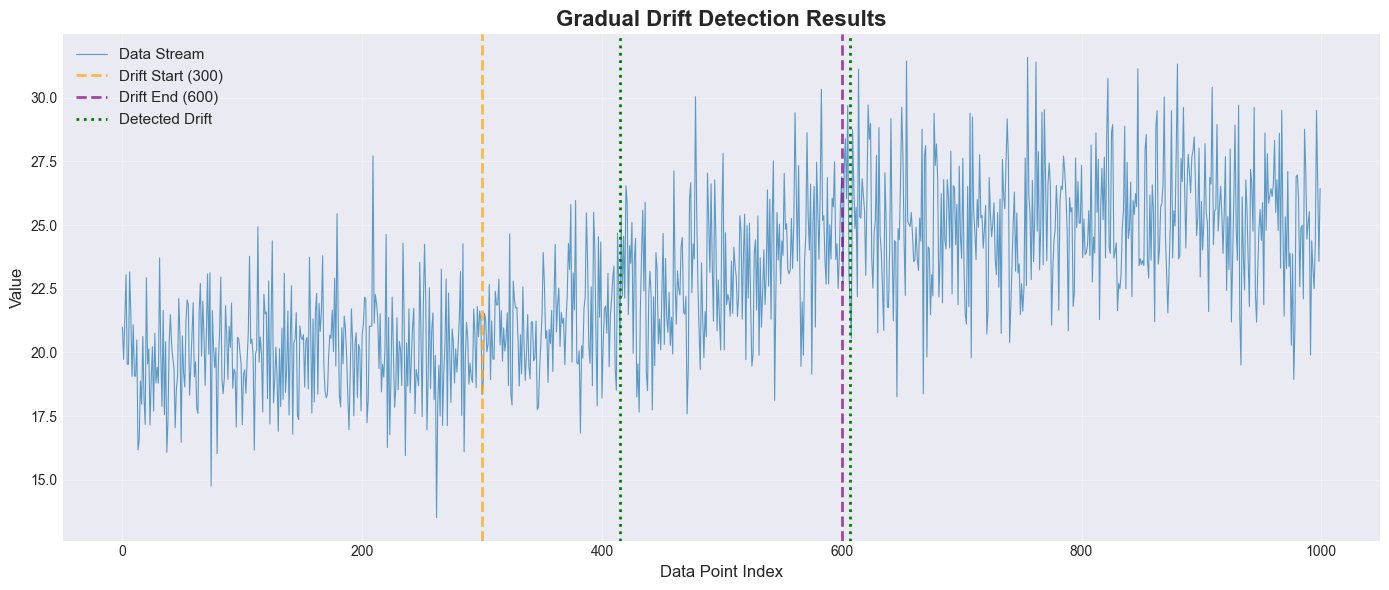


Observation: Gradual drift is harder to detect and may trigger multiple alerts.
The detector identifies changes throughout the transition period.


In [27]:
# Visualize gradual drift detection
plt.figure(figsize=(14, 6))
plt.plot(gradual_stream, alpha=0.7, linewidth=0.8, label='Data Stream')
plt.axvline(x=300, color='orange', linestyle='--', linewidth=2, label='Drift Start (300)', alpha=0.7)
plt.axvline(x=600, color='purple', linestyle='--', linewidth=2, label='Drift End (600)', alpha=0.7)

for idx, drift_point in enumerate(gradual_drift_points):
    if idx == 0:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2, 
                   label=f'Detected Drift')
    else:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2)

plt.title('Gradual Drift Detection Results', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: Gradual drift is harder to detect and may trigger multiple alerts.")
print("The detector identifies changes throughout the transition period.")

### 6.2 Practical Strategies for Gradual Drift

**How to Handle Multiple Detections:**

1. **Aggregation Window**: Group detections within a time window (e.g., 50 data points)
   - If 3+ detections occur within 50 points, consider it one drift event

2. **Cooldown Period**: After detecting drift, pause alerts for N data points
   - Prevents alert fatigue from repeated notifications

3. **Threshold-Based**: Trigger action only after detecting drift X times in Y points
   - Example: 3 detections in 100 points = likely real drift

4. **Combine with Performance Monitoring**: Correlate drift detection with model accuracy
   - If drift detected AND accuracy drops → high confidence to retrain

**Code Example for Production:**
```python
# Pseudocode for production drift handling
cooldown_remaining = 0
drift_window = []

for data_point in stream:
    detector.update(data_point)
    
    if detector.drift_detected and cooldown_remaining == 0:
        drift_window.append(current_index)
        
        # Check if multiple drifts in window
        if len(drift_window) >= 3:
            trigger_retraining()
            cooldown_remaining = 100  # Pause for 100 points
            drift_window.clear()
    
    cooldown_remaining = max(0, cooldown_remaining - 1)
```

## 7. Comparing Different Drift Detectors

The `river` library provides several drift detection algorithms. Let's compare ADWIN with another popular detector: **DDM (Drift Detection Method)**.

### DDM (Drift Detection Method)

DDM monitors the error rate of an online learner. It's based on the assumption that the error rate will increase when drift occurs. DDM is particularly effective for classification problems.

### 7.1 Understanding DDM (Drift Detection Method)

**What Makes DDM Different from ADWIN?**

| Feature | ADWIN | DDM |
|---------|-------|-----|
| **Input Data** | Any numerical values | Binary (0/1) - correct/incorrect predictions |
| **Use Case** | General data drift | Classification model performance |
| **What It Monitors** | Distribution of values | Error rate pattern |
| **Best For** | Feature drift, data changes | Concept drift, model degradation |

**How DDM Works:**

DDM monitors the **error rate** of predictions and uses statistical process control:

1. **Baseline**: Establishes normal error rate during initial stable period
2. **Warning Level**: Error rate increases beyond expected variance
   - Signal: "Something might be changing, keep watching"
3. **Drift Level**: Error rate significantly exceeds normal bounds
   - Signal: "Drift confirmed, take action!"

**Key Insight**: DDM assumes that when the relationship between features and target changes (concept drift), the model's error rate will increase.

**When to Use DDM:**
- ✅ Monitoring classification model performance
- ✅ When you have ground truth labels (even with delay)
- ✅ Detecting concept drift specifically
- ✅ Binary or multi-class classification problems

**Limitations:**
- ❌ Requires labeled data (true outcomes)
- ❌ Not suitable for regression problems
- ❌ Won't detect data drift if model performance doesn't change

In [28]:
# Simulate a classification scenario with drift
np.random.seed(42)

# Before drift: model has 10% error rate
errors_before = np.random.choice([0, 1], size=500, p=[0.9, 0.1])

# After drift: model has 30% error rate (performance degraded)
errors_after = np.random.choice([0, 1], size=500, p=[0.7, 0.3])

# Combine error streams
error_stream = np.concatenate([errors_before, errors_after])

print(f"Classification error stream created:")
print(f"  - Before drift (0-499): ~10% error rate")
print(f"  - After drift (500-999): ~30% error rate")
print(f"  - Actual error rate before: {errors_before.mean()*100:.1f}%")
print(f"  - Actual error rate after: {errors_after.mean()*100:.1f}%")

Classification error stream created:
  - Before drift (0-499): ~10% error rate
  - After drift (500-999): ~30% error rate
  - Actual error rate before: 11.0%
  - Actual error rate after: 26.8%


### 7.2 Creating a Realistic Classification Scenario

**The Scenario:**

Imagine a spam email classifier deployed in production:
- **Initially**: The model correctly identifies 90% of emails (10% error rate)
- **After Drift**: Spammers adapt their tactics, and the model's accuracy drops to 70% (30% error rate)

**Why This Happens (Concept Drift):**
- Spammers learn to avoid common spam words the model looks for
- New types of phishing attacks emerge
- The relationship between email features and "spam/not spam" has changed

**Data Representation:**
- `0` = Model made correct prediction
- `1` = Model made incorrect prediction (error)

We'll simulate 1000 email predictions, with drift occurring at position 500.

In [30]:
from river.drift.binary import DDM

In [31]:
# Use DDM to detect drift
ddm = DDM()
ddm_drift_points = []
ddm_warning_points = []

print("\nDetecting drift with DDM...\n")

for i, error in enumerate(error_stream):
    # DDM expects binary input (0 = correct, 1 = error)
    ddm.update(error)
    
    if ddm.drift_detected:
        print(f"Drift detected at index: {i}")
        ddm_drift_points.append(i)

print(f"\nTotal drift points detected by DDM: {len(ddm_drift_points)}")


Detecting drift with DDM...

Drift detected at index: 55
Drift detected at index: 139
Drift detected at index: 248
Drift detected at index: 412
Drift detected at index: 446
Drift detected at index: 518

Total drift points detected by DDM: 6


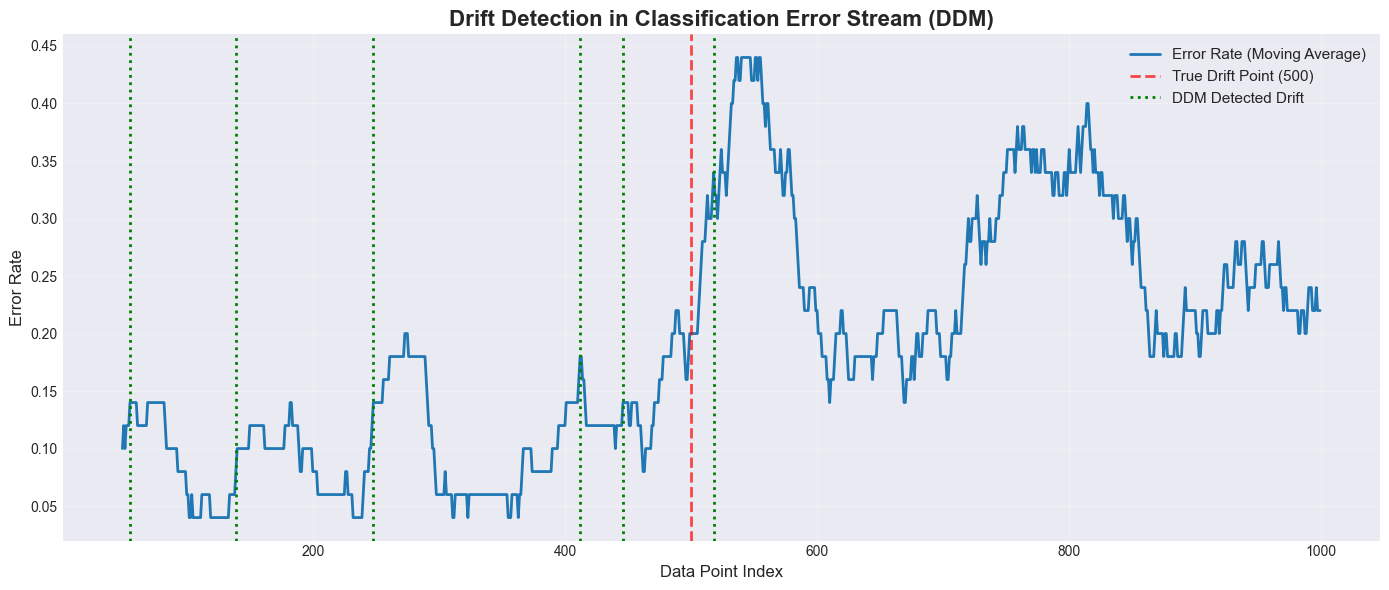


DDM is particularly effective for detecting drift in classification performance.


In [32]:
# Visualize error rates and detected drift
# Calculate moving average of errors for visualization
window_size = 50
moving_avg = np.convolve(error_stream, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(14, 6))
plt.plot(range(window_size-1, len(error_stream)), moving_avg, 
         linewidth=2, label='Error Rate (Moving Average)')
plt.axvline(x=500, color='red', linestyle='--', linewidth=2, 
           label='True Drift Point (500)', alpha=0.7)

for idx, drift_point in enumerate(ddm_drift_points):
    if idx == 0:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2, 
                   label=f'DDM Detected Drift')
    else:
        plt.axvline(x=drift_point, color='green', linestyle=':', linewidth=2)

plt.title('Drift Detection in Classification Error Stream (DDM)', fontsize=16, fontweight='bold')
plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDDM is particularly effective for detecting drift in classification performance.")

### 7.3 Interpreting DDM Results

**What the Visualization Shows:**

The moving average smooths out individual prediction errors to show the overall trend:
- **Flat line** around 0.1 (10%) before index 500 = Good performance
- **Sharp increase** to 0.3 (30%) after index 500 = Performance degradation
- **Green line(s)** = When DDM detected the drift

**Key Observations:**

1. **Detection Timing**: DDM typically detects drift shortly after the error rate increases
   - It needs to accumulate evidence (multiple errors) before signaling drift
   - This is why detection might lag by 20-100 data points

2. **Statistical Confidence**: DDM uses hypothesis testing
   - It waits until it's statistically confident the increase is real, not just random variance
   - This prevents false alarms from occasional bad predictions

3. **Comparison with ADWIN**:
   - **ADWIN**: Detects *any* distribution change in the data
   - **DDM**: Detects *performance degradation* specifically
   - For production ML systems, use both: ADWIN for features, DDM for predictions

**Practical Implications:**

In a real system, this drift detection would trigger:
1. ✉️ **Alert**: Notify ML engineers of performance drop
2. 📊 **Investigation**: Analyze recent data for changes
3. 🔄 **Retraining**: Collect new labeled data and retrain model
4. 🚀 **Deployment**: Deploy updated model to restore performance

## 13. Key Takeaways and Best Practices

### Summary

In this notebook, we've explored:

1. **What model drift is**: The degradation of model performance over time due to changes in data
2. **Types of drift**: Concept drift, data drift, and upstream data changes
3. **Drift patterns**: Sudden, gradual, incremental, and recurring drift
4. **Detection methods**: ADWIN for general drift detection and DDM for classification scenarios
5. **Practical implementation**: How to use the `river` library to detect drift in Python
6. **Real-world application**: Complete ML pipeline with drift monitoring
7. **Production strategies**: Combining multiple signals for robust monitoring

### Best Practices for Production Systems

1. **Monitor Continuously**: Set up automated drift detection in your ML pipelines
2. **Choose Appropriate Detectors**: Select algorithms based on your data type and drift patterns
3. **Set Thresholds Carefully**: Balance between false positives and detection delay
4. **Combine Multiple Signals**: Use both performance metrics and drift detectors
5. **Establish Retraining Protocols**: Have a plan for when drift is detected
6. **Log and Analyze**: Keep records of detected drifts for pattern analysis
7. **Test Drift Scenarios**: Simulate different types of drift during model development
8. **Don't Over-React**: Not every drift detection means immediate retraining
9. **Business Context Matters**: Align drift sensitivity with business costs of errors
10. **Automate Responsibly**: Have human review for high-stakes decisions

### When to Retrain Your Model

Consider retraining when:
- ✅ Drift is detected consistently over multiple periods
- ✅ Model performance metrics drop below acceptable thresholds
- ✅ Business metrics (e.g., conversion rates, revenue) are affected
- ✅ Multiple drift signals converge (features + performance)
- ✅ Major events occur that likely affect your domain (e.g., regulatory changes, market shifts)

Consider NOT retraining when:
- ❌ Single isolated drift detection (might be noise)
- ❌ Drift detected but performance remains acceptable
- ❌ Temporary data quality issues (fix data pipeline instead)
- ❌ Cost of retraining exceeds cost of slightly degraded performance

### The Drift Detection Lifecycle

```
1. Design Phase
   └── Choose drift detectors based on model type
   └── Set sensitivity parameters
   └── Define alerting thresholds

2. Deployment Phase
   └── Implement monitoring in production
   └── Log all relevant metrics
   └── Set up dashboards

3. Monitoring Phase
   └── Continuously track drift signals
   └── Correlate with business KPIs
   └── Investigate alerts

4. Response Phase
   └── Validate drift is real
   └── Collect new training data
   └── Retrain and evaluate
   └── Deploy with A/B testing

5. Learning Phase
   └── Analyze drift patterns
   └── Adjust detector parameters
   └── Update retraining protocols
   └── Document lessons learned
```

### Final Thoughts

**Model drift is inevitable.** Real-world data distributions change, user behaviors evolve, and business environments shift. The question is not *if* your model will experience drift, but *when* and *how well you'll detect it*.

By implementing robust drift detection and monitoring, you ensure that your ML systems remain reliable, trustworthy, and valuable to your organization over time.

**Remember**: A model without monitoring is like a ship without a compass - you might stay on course for a while, but eventually, you'll drift off target without even knowing it! 🚢

### Additional Resources

- **River Documentation**: https://riverml.xyz/
- **Evidently AI**: Another excellent library for ML monitoring
- **Research Papers**: Look up "concept drift detection" on Google Scholar
- **MLOps Practices**: Study continuous training and monitoring patterns
- **Coursera/edX**: Search for MLOps courses that cover model monitoring

## 9. Choosing the Right Drift Detection Strategy

### Decision Framework

Use this guide to select the appropriate drift detection approach for your use case:

#### **1. If You Have a Classification Model with Ground Truth Labels:**

**Use DDM (or similar performance-based detectors)**
- ✅ Directly monitors what matters: model performance
- ✅ Detects concept drift (when relationships change)
- ✅ Simple to interpret: "error rate increased"
- Example: Fraud detection, spam filtering, churn prediction

#### **2. If You Need to Monitor Feature Distributions:**

**Use ADWIN (or statistical tests)**
- ✅ Detects data drift before it affects performance
- ✅ No need for labels
- ✅ Can monitor individual features or predictions
- Example: Sensor monitoring, input data validation, feature engineering pipelines

#### **3. If You Have a Regression Model:**

**Use ADWIN on Prediction Errors**
- Monitor: `|predicted_value - actual_value|`
- Can also use: ADWIN on feature distributions
- Alternative: PageHinkley test for regression errors

#### **4. For Comprehensive Monitoring (Recommended for Production):**

**Use Multiple Detectors:**
```
├── Feature-Level: ADWIN on each important feature
├── Prediction-Level: ADWIN on model outputs
├── Performance-Level: DDM on prediction errors (if labels available)
└── Business-Level: Monitor business KPIs
```

### Comparison Table

| Detector | Input Type | Best For | Requires Labels | Detection Speed |
|----------|-----------|----------|-----------------|-----------------|
| **ADWIN** | Continuous values | Data/Feature drift | ❌ No | Fast |
| **DDM** | Binary (0/1) | Performance drift | ✅ Yes | Medium |
| **KSWIN** | Continuous values | Distribution changes | ❌ No | Medium |
| **PageHinkley** | Continuous values | Mean shifts | ❌ No | Very Fast |
| **EDDM** | Binary (0/1) | Gradual concept drift | ✅ Yes | Slow |

### Practical Tips

1. **Start Simple**: Begin with one detector, add more as needed
2. **Tune Carefully**: Test different sensitivity parameters on historical data
3. **Set Up Baselines**: Run detectors on stable data to establish false positive rates
4. **Combine Signals**: Don't rely on a single detector - use multiple indicators
5. **Monitor Business Metrics**: Drift detection should align with business impact

## 10. Real-World Application: Complete ML Pipeline with Drift

Now let's see how drift affects an actual machine learning model. We'll build a complete example showing:
1. Training a model on initial data
2. Simulating production data with drift
3. Detecting both data drift and performance degradation
4. Understanding when to retrain

### The Scenario: Customer Churn Prediction

We'll create a binary classification model that predicts whether customers will churn (leave the service).
- **Initial Period**: Customer behavior patterns are stable
- **Drift Period**: Market conditions change, affecting customer behavior
- **Goal**: Detect when our model's predictions become unreliable

In [33]:
# Import additional libraries for ML model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Set random seed
np.random.seed(42)

# Create initial training data
print("Step 1: Creating Initial Training Dataset")
print("=" * 50)

X_train, y_train = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_classes=2,
    random_state=42,
    flip_y=0.1  # 10% label noise (realistic scenario)
)

print(f"Training set size: {len(X_train)} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"Class distribution: {np.bincount(y_train)}")
print(f"Class balance: {y_train.mean():.2%} positive class")

# Train the model
print("\nStep 2: Training Logistic Regression Model")
print("=" * 50)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Evaluate on training data
train_predictions = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

print(f"Training accuracy: {train_accuracy:.2%}")
print("\nModel trained successfully! ✓")

Step 1: Creating Initial Training Dataset
Training set size: 1000 samples
Number of features: 10
Class distribution: [505 495]
Class balance: 49.50% positive class

Step 2: Training Logistic Regression Model
Training accuracy: 67.00%

Model trained successfully! ✓


In [34]:
# Simulate production data stream with concept drift
print("Step 3: Simulating Production Data Stream")
print("=" * 50)

# Period 1: Stable - Similar to training data (500 samples)
X_stable, y_stable = make_classification(
    n_samples=500,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_classes=2,
    random_state=100,
    flip_y=0.1
)

# Period 2: Drifted - Changed relationship (500 samples)
# Simulate concept drift by:
# 1. Shifting feature means
# 2. Increasing class imbalance
# 3. Adding noise
X_drifted, y_drifted = make_classification(
    n_samples=500,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_classes=2,
    random_state=200,
    flip_y=0.25,  # More noise (concept became harder)
    weights=[0.7, 0.3],  # Class imbalance changed
    shift=2.0  # Feature distribution shifted
)

# Combine into production stream
X_production = np.vstack([X_stable, X_drifted])
y_production = np.concatenate([y_stable, y_drifted])

print(f"Production stream created:")
print(f"  - Stable period (0-499): Similar to training data")
print(f"  - Drifted period (500-999): Concept drift introduced")
print(f"\nStable period - Class balance: {y_stable.mean():.2%}")
print(f"Drifted period - Class balance: {y_drifted.mean():.2%}")
print(f"\nFeature 0 mean shift: {X_stable[:, 0].mean():.2f} → {X_drifted[:, 0].mean():.2f}")

Step 3: Simulating Production Data Stream
Production stream created:
  - Stable period (0-499): Similar to training data
  - Drifted period (500-999): Concept drift introduced

Stable period - Class balance: 51.00%
Drifted period - Class balance: 36.00%

Feature 0 mean shift: 0.43 → 2.26


In [35]:
# Monitor model performance and detect drift
print("Step 4: Monitoring Model Performance in Production")
print("=" * 50)

# Initialize drift detectors
adwin_feature = drift.ADWIN()  # Monitor feature drift
ddm_performance = DDM()  # Monitor performance drift

# Track metrics
predictions = []
actual_labels = []
prediction_errors = []
accuracies = []
feature_drift_points = []
performance_drift_points = []

# Simulate online learning scenario
window_size = 50  # Calculate accuracy every 50 predictions

print("\nProcessing production stream...\n")

for i in range(len(X_production)):
    # Get current sample
    X_current = X_production[i:i+1]
    y_current = y_production[i]
    
    # Make prediction
    y_pred = model.predict(X_current)[0]
    predictions.append(y_pred)
    actual_labels.append(y_current)
    
    # Calculate error (0 = correct, 1 = incorrect)
    error = int(y_pred != y_current)
    prediction_errors.append(error)
    
    # Monitor feature drift (using first feature as example)
    adwin_feature.update(X_current[0, 0])
    if adwin_feature.drift_detected:
        feature_drift_points.append(i)
        print(f"⚠️  Feature drift detected at index: {i}")
    
    # Monitor performance drift
    ddm_performance.update(error)
    if ddm_performance.drift_detected:
        performance_drift_points.append(i)
        print(f"🔴 Performance drift detected at index: {i}")
    
    # Calculate rolling accuracy
    if (i + 1) % window_size == 0:
        recent_errors = prediction_errors[-window_size:]
        accuracy = 1 - np.mean(recent_errors)
        accuracies.append(accuracy)

print(f"\nMonitoring complete!")
print(f"Feature drift detections: {len(feature_drift_points)}")
print(f"Performance drift detections: {len(performance_drift_points)}")

Step 4: Monitoring Model Performance in Production

Processing production stream...

⚠️  Feature drift detected at index: 543

Monitoring complete!
Feature drift detections: 1
Performance drift detections: 0


Step 5: Visualizing Model Performance Degradation


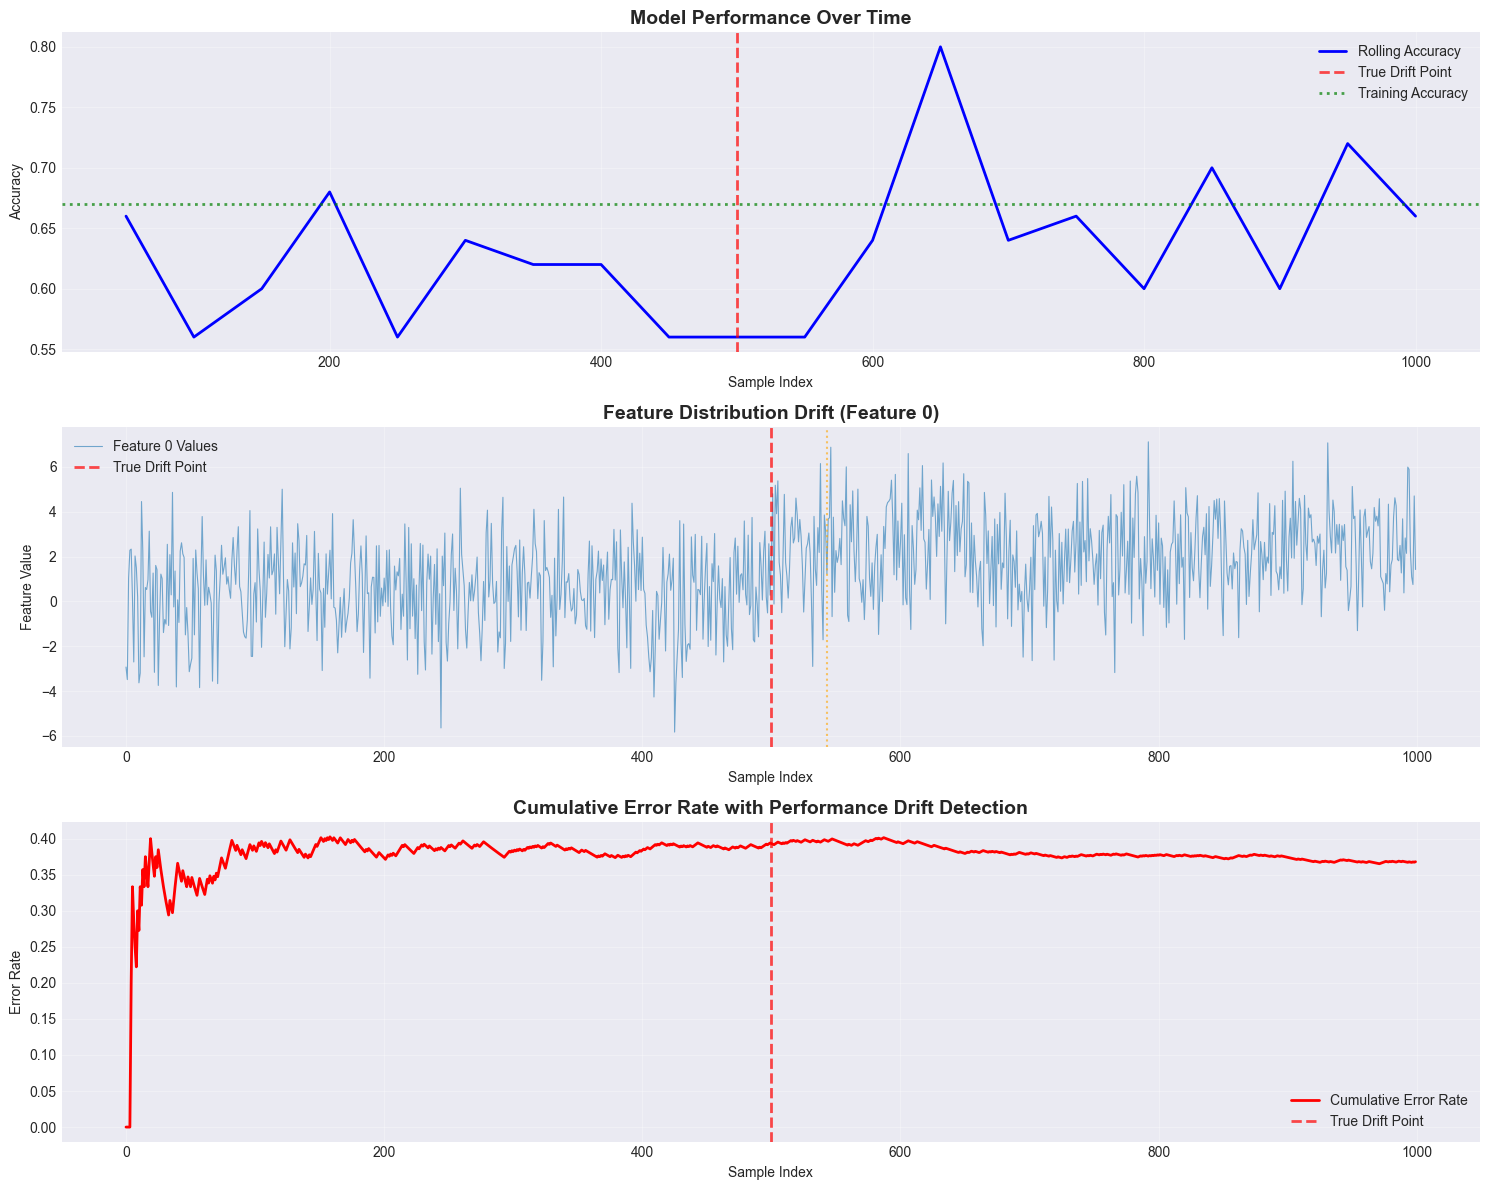


📊 Key Observations:
  • Accuracy before drift: 60.60%
  • Accuracy after drift: 65.80%
  • Performance drop: -5.20%
  • First performance drift detected at: N/A
  • Detection delay: N/A samples


In [36]:
# Visualize comprehensive drift monitoring results
print("Step 5: Visualizing Model Performance Degradation")
print("=" * 50)

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Rolling Accuracy
ax1 = axes[0]
accuracy_indices = np.arange(window_size, len(X_production) + 1, window_size)
ax1.plot(accuracy_indices, accuracies, linewidth=2, color='blue', label='Rolling Accuracy')
ax1.axvline(x=500, color='red', linestyle='--', linewidth=2, label='True Drift Point', alpha=0.7)
ax1.axhline(y=train_accuracy, color='green', linestyle=':', linewidth=2, label='Training Accuracy', alpha=0.7)
ax1.set_title('Model Performance Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Feature Distribution (Feature 0)
ax2 = axes[1]
feature_values = X_production[:, 0]
ax2.plot(feature_values, alpha=0.6, linewidth=0.8, label='Feature 0 Values')
ax2.axvline(x=500, color='red', linestyle='--', linewidth=2, label='True Drift Point', alpha=0.7)
for drift_point in feature_drift_points[:3]:  # Show first 3 to avoid clutter
    ax2.axvline(x=drift_point, color='orange', linestyle=':', linewidth=1.5, alpha=0.6)
ax2.set_title('Feature Distribution Drift (Feature 0)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Feature Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative Error Rate
ax3 = axes[2]
cumulative_errors = np.cumsum(prediction_errors) / np.arange(1, len(prediction_errors) + 1)
ax3.plot(cumulative_errors, linewidth=2, color='red', label='Cumulative Error Rate')
ax3.axvline(x=500, color='red', linestyle='--', linewidth=2, label='True Drift Point', alpha=0.7)
for drift_point in performance_drift_points[:3]:
    ax3.axvline(x=drift_point, color='purple', linestyle=':', linewidth=2, alpha=0.6)
ax3.set_title('Cumulative Error Rate with Performance Drift Detection', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Error Rate')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print(f"  • Accuracy before drift: {np.mean(accuracies[:10]):.2%}")
print(f"  • Accuracy after drift: {np.mean(accuracies[10:]):.2%}")
print(f"  • Performance drop: {(np.mean(accuracies[:10]) - np.mean(accuracies[10:])):.2%}")
print(f"  • First performance drift detected at: {performance_drift_points[0] if performance_drift_points else 'N/A'}")
print(f"  • Detection delay: {performance_drift_points[0] - 500 if performance_drift_points else 'N/A'} samples")

### 10.1 Understanding the Complete Picture

**What We Just Demonstrated:**

This example shows the **complete lifecycle** of model drift in production:

1. **Training Phase**: Model achieves good accuracy on historical data
2. **Stable Production**: Model performs well initially (samples 0-499)
3. **Drift Occurs**: Real-world conditions change at sample 500
4. **Detection**: Our monitoring system catches both:
   - **Feature Drift**: Input data distribution changes (ADWIN)
   - **Performance Drift**: Prediction accuracy drops (DDM)
5. **Decision Point**: Time to retrain or update the model

**Three Key Metrics to Monitor:**

| Metric | What It Shows | When to Alert |
|--------|---------------|---------------|
| **Rolling Accuracy** | Current model performance | Drops below threshold |
| **Feature Distribution** | Input data changes | Statistical shift detected |
| **Error Rate Trend** | Long-term degradation | Sustained increase |

**Why Monitor Multiple Signals?**

- **Feature Drift Alone**: May not impact performance (false alarm)
- **Performance Drift Alone**: May be temporary (data quality issue)
- **Both Together**: Strong signal that retraining is needed ✅

**Real-World Decision Logic:**

```python
if feature_drift_detected AND performance_drift_detected:
    if accuracy < performance_threshold:
        # High confidence: Trigger retraining
        initiate_retraining_pipeline()
    else:
        # Medium confidence: Investigate
        send_alert_to_ml_team()
elif performance_drift_detected:
    # Performance drop without feature drift
    # Could be: data quality issue, labeling problem
    investigate_data_quality()
elif feature_drift_detected:
    # Feature drift without performance drop
    # Monitor closely, but don't retrain yet
    increase_monitoring_frequency()
```

**Key Takeaway**: Always combine multiple monitoring signals before taking action. One detector alone can produce false positives, but converging evidence from multiple detectors gives you confidence to act.

## 11. Practice Exercises

Now it's your turn to apply what you've learned! Try these exercises to deepen your understanding.

### Exercise 1: Experiment with ADWIN Sensitivity ⭐

**Task**: Modify the ADWIN detector's `delta` parameter and observe how it affects drift detection.

**Steps**:
1. Go back to the sudden drift example (Section 5)
2. Try `delta=0.1` (less sensitive) and `delta=0.0001` (more sensitive)
3. Compare detection timing and number of drift points

**Questions to Answer**:
- Which delta value detects drift fastest?
- Which delta value has more false positives?
- What delta would you choose for a production system where false alarms are costly?

### Exercise 2: Create Your Own Drift Scenario ⭐⭐

**Task**: Create a data stream with **recurring drift** (seasonal pattern).

**Hint**:
```python
# Create a stream that oscillates between two distributions
stream = []
for i in range(1000):
    if (i // 100) % 2 == 0:  # Every 100 points, switch
        stream.append(np.random.normal(20, 2))
    else:
        stream.append(np.random.normal(25, 2))
```

**Questions to Answer**:
- How does ADWIN handle recurring drift?
- What happens to the number of detected drift points?
- How would you design a detector specifically for seasonal patterns?

### Exercise 3: Multi-Feature Drift Monitoring ⭐⭐⭐

**Task**: Extend the ML pipeline example (Section 10) to monitor **multiple features** simultaneously.

**Steps**:
1. Create one ADWIN detector for each feature
2. Track which features drift and when
3. Visualize which features are most affected by drift

**Challenge**: Can you identify which feature drift most strongly correlates with performance drop?

### Exercise 4: Implement a Retraining Decision System ⭐⭐⭐

**Task**: Build a simple decision system that determines when to retrain based on multiple signals.

**Requirements**:
- Monitor at least 3 signals (feature drift, performance drift, accuracy)
- Implement a scoring system (e.g., each signal = 1 point)
- Trigger "retrain" when score exceeds threshold
- Count how many false alarms vs. true retraining triggers

**Bonus**: Add a cooldown period to prevent retraining too frequently.

---

**💡 Tips for Success**:
- Start with Exercise 1 to build intuition
- Use print statements to track detector states
- Visualize everything - plots make patterns obvious
- Compare your results with classmates - different approaches are valuable!

**📝 Reflection Questions**:
1. In what situations might drift detection fail?
2. How would you handle drift in a system with delayed labels (e.g., loan defaults)?
3. What business considerations affect your choice of drift detector sensitivity?

## 12. Additional Tools and Resources

### Beyond River: Other Drift Detection Libraries

While we used the `river` library in this notebook, here are other excellent tools for production ML monitoring:

#### **1. Evidently AI** 🔍
```python
# pip install evidently
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
```
- **Best For**: Comprehensive monitoring dashboards and reports
- **Features**: 
  - Visual reports (HTML)
  - Multiple statistical tests
  - Feature-level drift analysis
  - Model performance monitoring
- **Use Case**: Batch monitoring, generating reports for stakeholders

#### **2. Alibi Detect** 🎯
```python
# pip install alibi-detect
from alibi_detect.cd import MMDDrift, KSDrift
```
- **Best For**: Advanced statistical tests and deep learning drift detection
- **Features**:
  - Maximum Mean Discrepancy (MMD)
  - Kolmogorov-Smirnov test
  - Chi-square test
  - Deep learning-based detectors
- **Use Case**: Research, complex high-dimensional data

#### **3. NannyML** 👶
```python
# pip install nannyml
import nannyml as nml
```
- **Best For**: Post-deployment monitoring without ground truth labels
- **Features**:
  - Estimated performance (without labels!)
  - Multivariate drift detection
  - Business value tracking
- **Use Case**: When labels are delayed or expensive

#### **4. Great Expectations** ✅
```python
# pip install great_expectations
import great_expectations as gx
```
- **Best For**: Data quality and validation
- **Features**:
  - Data profiling
  - Expectation-based testing
  - Integration with data pipelines
- **Use Case**: Data quality monitoring, upstream drift detection

### Statistical Tests for Drift Detection

Beyond ADWIN and DDM, here are common statistical approaches:

| Test | Data Type | What It Detects | Python Implementation |
|------|-----------|-----------------|----------------------|
| **Kolmogorov-Smirnov** | Continuous | Distribution changes | `scipy.stats.ks_2samp()` |
| **Chi-Square** | Categorical | Category distribution | `scipy.stats.chisquare()` |
| **Population Stability Index (PSI)** | Both | Distribution shift | Custom or `evidently` |
| **Jensen-Shannon Divergence** | Both | Distribution similarity | `scipy.spatial.distance.jensenshannon()` |
| **Wasserstein Distance** | Continuous | Distribution difference | `scipy.stats.wasserstein_distance()` |

### Quick Example: Using Kolmogorov-Smirnov Test

```python
from scipy.stats import ks_2samp

# Compare two distributions
stat, p_value = ks_2samp(stream_1, stream_2)

if p_value < 0.05:  # 95% confidence
    print(f"Drift detected! p-value: {p_value:.4f}")
else:
    print(f"No significant drift. p-value: {p_value:.4f}")
```

### Production Monitoring Architecture

**Recommended Setup for Production ML Systems:**

```
┌─────────────────────────────────────────────────┐
│         Production ML System                     │
├─────────────────────────────────────────────────┤
│                                                  │
│  📊 Data Collection Layer                       │
│     ├── Log predictions                         │
│     ├── Log features                            │
│     └── Log ground truth (when available)       │
│                                                  │
│  🔍 Monitoring Layer                            │
│     ├── Feature drift detectors (ADWIN)         │
│     ├── Prediction drift monitors               │
│     ├── Performance trackers (DDM)              │
│     └── Business metric monitors                │
│                                                  │
│  📈 Alerting Layer                              │
│     ├── Dashboard (Grafana/Evidently)           │
│     ├── Alerts (PagerDuty/Slack)               │
│     └── Reports (Weekly summaries)              │
│                                                  │
│  🔄 Response Layer                              │
│     ├── Automated retraining triggers           │
│     ├── Model rollback capabilities             │
│     └── A/B testing framework                   │
│                                                  │
└─────────────────────────────────────────────────┘
```

### Further Reading

**Academic Papers:**
- "Learning under Concept Drift: A Review" - Gama et al. (2014)
- "A Survey on Concept Drift Adaptation" - Lu et al. (2018)
- "ADWIN: Adaptive Windowing for Mining Data Streams" - Bifet & Gavaldà (2007)

**Online Resources:**
- River Documentation: https://riverml.xyz/
- Evidently AI Blog: https://evidentlyai.com/blog
- Made With ML - MLOps: https://madewithml.com/
- Google's ML Crash Course: https://developers.google.com/machine-learning/crash-course

**Tools to Explore:**
- MLflow for experiment tracking
- Weights & Biases for model monitoring
- WhyLabs for data logging and monitoring
- Arize AI for ML observability

### Next Steps for Your Learning Journey

1. ✅ **Complete the practice exercises** in Section 11
2. 📚 **Read about different drift types** in academic papers
3. 🛠️ **Implement monitoring** in your own ML projects
4. 🔬 **Experiment with different detectors** on real datasets
5. 🏗️ **Build a complete monitoring pipeline** using Evidently or NannyML
6. 🚀 **Deploy a model with drift detection** in production

Remember: **Drift detection is not optional for production ML systems** - it's a critical component of responsible AI deployment!